# Chapter 20:  Phase Estimation
### Qiskit 1.0 (0.46)

## Example with $T$ Gate

The  $T$ gate corresponds to the unitary matrix
\begin{equation}

T= \left( \begin{array}{cc} 
 1 & 0\\
 0   &   e^{i \frac{\pi}{4}}  \\
 \end{array} \right).
\end{equation}

 With the eigenvector $|1 \rangle$ and the eigenvalue $ e^{ 2\cdot \pi \cdot i \cdot \theta}$

\begin{equation}
U \cdot|u \rangle = T \cdot|1 \rangle =e^{ 2\cdot \pi \cdot i \cdot \theta} \cdot |u \rangle=e^{ 2\cdot \pi \cdot i \cdot \theta} \cdot |1 \rangle
\end{equation}

with the phase is $\theta= \frac{1}{8}$ since

\begin{equation}
  T | 1 \rangle = e^{ 2\cdot \pi \cdot i \cdot \theta} = e^{i \frac{\pi}{4}} \cdot |1 \rangle  = e^{2 \cdot i \frac{\pi}{8}} \cdot |1 \rangle.   
\end{equation}

The phase estimation algorithm will write the phase of $T$  to the  $m$ qubits in the control register.  The value of $m$ determines the precision of the result.
In our simple case $m=3$ 

\begin{equation}
\theta= 0. x_3 x_2x_1=\frac{x}{8}=\frac{x}{2^3}.
\end{equation}

The controlled $T$ gate is represented by the  controlled phase gate  $CP(\lambda)$ with  $\lambda=\pi/4$.
The circuit is composed of $4$ qubits, qubits $0$, $1$, $2$ represent the  $3$ qubits in the control register. The qubit $3$ represents the eigenvector  $|1 \rangle$.
The control register is mapped into superposition by Hadamard gates and the qubit  $4$ is initialized to the  eigenvector  $|1 \rangle$ with the NOT gate.
The control register controls the unitary operations $T$ applied to the target  eigenvector   $|1 \rangle$ resulting in the Fourier basis representation of the three control qubits. To estimate the phase $\theta$ we perform the inverse QFT  to the $3$ control qubits and measure the three quits  and estimate $\theta$ with 

\begin{equation}
x=| q_2q_1q_0 \rangle
\end{equation}

and

\begin{equation}
\theta= \frac{x}{2^3}.
\end{equation}

The circuit is represented as

In [17]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_distribution 
from qiskit.circuit.library import MCXGate
from math import pi
from qiskit.circuit.library import QFT

In [18]:
qc = QuantumCircuit(4, 3)
qc.h(0)
qc.h(1)
qc.h(2)
qc.x(3)

#qc.cp(lambda, control, target)

qc.cp(pi/4, 0, 3)

qc.cp(pi/4, 1, 3)
qc.cp(pi/4, 1, 3)

qc.cp(pi/4, 2, 3)
qc.cp(pi/4, 2, 3)
qc.cp(pi/4, 2, 3)
qc.cp(pi/4, 2, 3)

qc.barrier()

qc = qc.compose(QFT(3, inverse=True), [0,1,2])

qc.barrier()

qc.measure(0,0)
qc.measure(1,1)
qc.measure(2,2)

qc.draw(fold=200)

┌───┐                                                                ░ ┌──────────┐ ░ ┌─┐      
q_0: ┤ H ├─■──────────────────────────────────────────────────────────────░─┤0         ├─░─┤M├──────
     ├───┤ │                                                              ░ │          │ ░ └╥┘┌─┐   
q_1: ┤ H ├─┼────────■────────■────────────────────────────────────────────░─┤1 IQFT_dg ├─░──╫─┤M├───
     ├───┤ │        │        │                                            ░ │          │ ░  ║ └╥┘┌─┐
q_2: ┤ H ├─┼────────┼────────┼────────■────────■────────■────────■────────░─┤2         ├─░──╫──╫─┤M├
     ├───┤ │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  ░ └──────────┘ ░  ║  ║ └╥┘
q_3: ┤ X ├─■────────■────────■────────■────────■────────■────────■────────░──────────────░──╫──╫──╫─
     └───┘                                                                ░              ░  ║  ║  ║ 
c: 3/═══════════════════════════════════════════════════════════════════════════════════════╩══╩══╩═
                                                                                            0  1  2

Circuit estimating the phase of a $T$ gate with accuracy of three qubits. 
The circuit is composed of $4$ qubits, qubits $0$, $1$, $2$ represent the control register and qubit $3$ represents the eigenvector  $|1 \rangle$.
The control register controls the unitary operations $T$ applied to the target  eigenvector   $|1 \rangle$. To estimate the phase $\theta$ we perform the inverse QFT  to the $3$ control qubits.


Total count are: {'001': 1000}


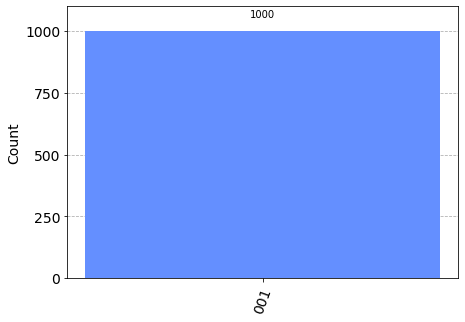

In [19]:
simulator = Aer.get_backend('qasm_simulator')
result=simulator.run(qc.decompose(),shots=1000).result()
counts = result.get_counts()
print("\nTotal count are:",counts)
plot_histogram(counts)

The measured value corresponds to the binary value $001$ equal to one indicating phase $\theta=0.125=1/2^3$

## Quantum Counting

The controlled Grover operator is implemented using use the circuit library with an  oracle that marks four solutions ($k=4$) out of $16$ states ($m^*=4)$

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import math


In [21]:
def grover_operator():
    #Grover iteration circuit for oracle with 4/16 solutions
    from qiskit.circuit.library import Diagonal, GroverOperator
    oracle = Diagonal([1,1,-1,1,1,1,1,1,1,1,1,1,-1,-1,-1,1])
    grover_it = GroverOperator(oracle).to_gate()
    grover_it.label = "G"
    return grover_it

and we will use the $.control()$ method to create a controlled gate from from the Grover operator. The circuit is composed of $8$ qubits, qubits $0$, $1$, $2$, $3$ represent the  $4$ qubits in the control register. The qubits $5$ to $7$ represents the four qubits  in the computational basis representing $16$ states.
All qubits are  mapped into superposition by Hadamard gates. 
The control register controls the unitary operations $G$ by the control method  $.control()$ with the first qubit being the control qubit of the control register.
 resulting in the Fourier basis representation of the three control qubits. To estimate the phase $\theta$ we perform the inverse QFT  to the $4$ control qubits and measure the four quits  and estimate $\theta$

In [22]:
from qiskit.circuit.library import QFT
qft_dagger = QFT(4, inverse=True).to_gate()
qft_dagger.label = "QFT†"

In [23]:
qc = QuantumCircuit(8, 4) 

qc.h([0,1,2,3,4,5,6,7])

cgrit = grover_operator().control()

qc.append(cgrit, [0,4,5,6,7])
   
qc.append(cgrit, [1,4,5,6,7])
qc.append(cgrit, [1,4,5,6,7])

qc.append(cgrit, [2,4,5,6,7])
qc.append(cgrit, [2,4,5,6,7])
qc.append(cgrit, [2,4,5,6,7])
qc.append(cgrit, [2,4,5,6,7])


qc.append(cgrit, [3,4,5,6,7])
qc.append(cgrit, [3,4,5,6,7])
qc.append(cgrit, [3,4,5,6,7])
qc.append(cgrit, [3,4,5,6,7])
qc.append(cgrit, [3,4,5,6,7])
qc.append(cgrit, [3,4,5,6,7])
qc.append(cgrit, [3,4,5,6,7])
qc.append(cgrit, [3,4,5,6,7])

# Do inverse QFT on counting qubits
qc.append(qft_dagger, [0,1,2,3])

# Measure counting qubits
qc.measure([0,1,2,3], [0,1,2,3])

# Display the circuit
qc.draw(fold=220)

┌───┐                                                                                          ┌───────┐┌─┐         
q_0: ┤ H ├──■───────────────────────────────────────────────────────────────────────────────────────┤0      ├┤M├─────────
     ├───┤  │                                                                                       │       │└╥┘┌─┐      
q_1: ┤ H ├──┼─────■─────■───────────────────────────────────────────────────────────────────────────┤1      ├─╫─┤M├──────
     ├───┤  │     │     │                                                                           │  QFT† │ ║ └╥┘┌─┐   
q_2: ┤ H ├──┼─────┼─────┼─────■─────■─────■─────■───────────────────────────────────────────────────┤2      ├─╫──╫─┤M├───
     ├───┤  │     │     │     │     │     │     │                                                   │       │ ║  ║ └╥┘┌─┐
q_3: ┤ H ├──┼─────┼─────┼─────┼─────┼─────┼─────┼─────■─────■─────■─────■─────■─────■─────■─────■───┤3      ├─╫──╫──╫─┤M├
     ├───┤┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐┌─┴──┐└───────┘ ║  ║  ║ └╥┘
q_4: ┤ H ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├──────────╫──╫──╫──╫─
     ├───┤│    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    │          ║  ║  ║  ║ 
q_5: ┤ H ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├──────────╫──╫──╫──╫─
     ├───┤│  G ││  G ││  G ││  G ││  G ││  G ││  G ││  G ││  G ││  G ││  G ││  G ││  G ││  G ││  G │          ║  ║  ║  ║ 
q_6: ┤ H ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├──────────╫──╫──╫──╫─
     ├───┤│    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    │          ║  ║  ║  ║ 
q_7: ┤ H ├┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├──────────╫──╫──╫──╫─
     └───┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘          ║  ║  ║  ║ 
c: 4/═════════════════════════════════════════════════════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                                                              0  1  2  3

 The controlled Grover operator is implemented using use the circuit library with an  oracle that marks four solutions ($k=4$) out of $16$ states ($m^*=4)$. The circuit is composed of $8$ qubits, qubits $0$, $1$, $2$, $3$ represent the  $4$ qubits in the control register. The qubits $5$ to $7$ represents the four qubits   in the computational basis representing $16$ states.
All qubits are  mapped into superposition by Hadamard gates. 
The control register controls the unitary operations $G$ 
 resulting in the Fourier basis representation of the three control qubits. To estimate the phase $\theta$ we perform the inverse QFT  to the $4$ control qubits and measure the four quits.

simulator = Aer.get_backend('qasm_simulator')
result=execute(qc,simulator,shots=1000).result()
counts = result.get_counts()
print("\nTotal count are:",counts)

plot_histogram(counts)


Total count are: {'0110': 4, '0000': 12, '1000': 2, '0111': 2, '1010': 6, '1001': 3, '1100': 21, '0100': 24, '0011': 351, '0001': 17, '1011': 9, '1110': 78, '0101': 9, '0010': 97, '1111': 13, '1101': 352}


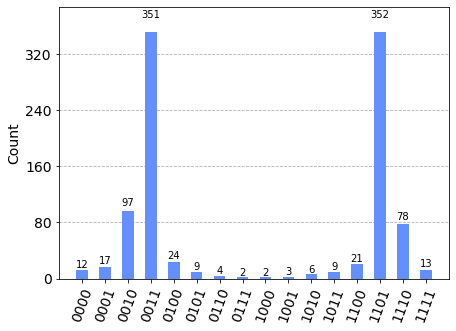

In [24]:
simulator = Aer.get_backend('qasm_simulator')
result=simulator.run(qc.decompose().decompose(),shots=1000).result()
counts = result.get_counts()
print("\nTotal count are:",counts)
plot_histogram(counts)

The maximal measured value corresponds to the binary value $0011$ ($3$ decimal) or $1101$  ($13$ decimal), see Figure  \ref{Phase_Estim_Grover_Count.eps} (b).
The phase is either  $\theta_1=\frac{ \pi \cdot 3}{16}$  or $\theta_2=\frac{\pi \cdot 13}{16}$ corresponding to the  two eigenvalues $\lambda_1=e^{ 2 \cdot i \theta}$ or $\lambda_2=e^{ - 2 \cdot i \theta}$ with positive and negative phase with

\begin{equation}
\sin^2 \left(\theta \right)=\sin^2 \left(-\theta \right)
\end{equation}
with approximately the correct answer

\begin{equation}
k=4.9 \approx   \sin^2 \left( \frac{ \pi \cdot 3}{16} \right) \cdot 16 = sin^2 \left( \frac{ \pi \cdot 13}{16} \right) \cdot 16.
\end{equation}
